In [42]:
import pandas as pd
from utils import Options
import pickle as pkl
import numpy as np
from glob import glob
from readresults.readres_mvpa import merge_results, parse_roi_info, \
    get_subj_avg, fill_in_nvoxels, quick_get_results, combine_splits_all
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
import seaborn as sns
from plotting.plot import plot_by_nvoxels
import pingouin as pg
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
tc = pd.read_csv('infocoupling/FIR_timecourses/sub-001_ba-17-18_contr-objscrvsbas_top-500.csv')

In [70]:
n_timepoints = tc.delay.nunique()

In [66]:
tc = tc.groupby(['delay', 'expected']).mean().reset_index()

In [76]:
exp_multivar_array = np.hstack(tc[tc.expected==True].distance).reshape(1, n_timepoints)
unexp_multivar_array = np.hstack(tc[tc.expected==False].distance).reshape(1, n_timepoints)

In [77]:
np.mean(exp_multivar_array, axis=1)

array([0.05074381])

In [81]:
roi = 'ba-17-18'
roi_basedir = '/project/3018040.05/anat_roi_masks'
mask_templ = os.path.join(roi_basedir, roi+'.nii')

opt = Options(
        sub='sub-001',
        roi=roi,
        task='test',
        model=27
    )

In [82]:
DS = load_betas(opt, mask_templ=mask_templ, fir=True)

100%|██████████| 329/329 [03:45<00:00,  1.46it/s]


In [83]:
DS = split_expunexp(DS)
n_voxels = DS.samples.shape[1]
nanmask = np.all(np.isfinite(DS.samples), axis=0)
DS = DS[:, nanmask]

In [84]:
brainmap = np.zeros(n_voxels)

In [86]:
brainmap[nanmask] = 1

In [88]:
brainmap.shape

(13412,)

In [59]:
univar_df = pd.DataFrame(
        {'delay': DS.sa.delay,
         'expected': DS.sa.expected,
         'samples': list(DS.samples)}
    )
univar_df = univar_df.groupby(['delay', 'expected']).mean().reset_index()

In [62]:
exp_univar_array = np.vstack(univar_df[univar_df.expected==1].samples).T

In [63]:
exp_univar_array.shape

(11959, 10)

In [78]:
correlations = np.dot(exp_univar_array, exp_multivar_array.T) / (n_timepoints - 1)

In [80]:
correlations.shape

(11959, 1)

In [36]:
meanacts = pd.DataFrame({
    'mean_activation': np.nanmean(DS.samples, axis=1),
    'delay': DS.sa.delay})

<AxesSubplot:xlabel='delay', ylabel='mean_activation'>

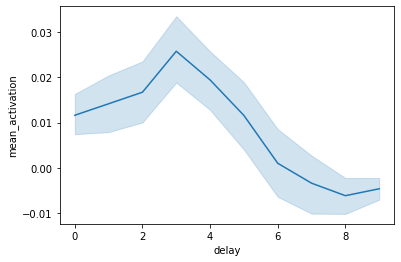

In [38]:
sns.lineplot(data=meanacts, x='delay', y='mean_activation')

In [33]:
np.nanmean(DS.samples, axis=1)

array([ 0.00389948,  0.01276095,  0.00619961,  0.00592604,  0.00291533,
       -0.00020063, -0.00537414, -0.00524818, -0.00425829, -0.0086823 ,
        0.00358138,  0.00656354, -0.00348091,  0.00623646,  0.01074966,
        0.01095719,  0.00030352, -0.00465014,  0.00321134,  0.00419845,
        0.01139264,  0.00736276, -0.00430459,  0.01018451,  0.00892047,
        0.00329142, -0.00814853, -0.00934182, -0.00617361,  0.00110029,
        0.00683377,  0.00438258,  0.00242913,  0.01053932,  0.00246452,
       -0.00636816, -0.00879785, -0.0036952 ,  0.00271836, -0.0010389 ,
        0.02769768,  0.03104717,  0.03407262,  0.04240933,  0.0331856 ,
        0.02642133,  0.00845229,  0.00214875, -0.00275137, -0.00037315,
        0.01742162,  0.02271179,  0.02061762,  0.02592507,  0.01713237,
        0.0081255 ,  0.00682532,  0.00318789, -0.00184334, -0.00109642,
        0.01342093,  0.02054021,  0.01781074,  0.03101134,  0.02187366,
        0.01589335,  0.01526138,  0.01054851, -0.00506446, -0.00

In [23]:
splitsresults = quick_get_results('../../MVPA_results/trysplits.csv')

In [24]:
splitsresults

,correct,output,rawdistance,distance,chunk,split,view,expected,subject,roi,approach,traindataformat,testdataformat,traintask,testtask,trainmodel,testmodel,hemi,contrast,nvoxels
0,0,0,6.740387,-1.292351,1,1.0,1,True,sub-001,ba-17-18,traintest,betas,betas,train,test,5,15,L,objscrvsbas,1000
1,0,1,-1.113025,-0.159367,1,1.0,1,True,sub-001,ba-17-18,traintest,betas,betas,train,test,5,15,L,objscrvsbas,1000
2,1,1,-11.306696,2.043687,2,1.0,1,True,sub-001,ba-17-18,traintest,betas,betas,train,test,5,15,L,objscrvsbas,1000
3,0,1,-1.486877,-0.228474,2,1.0,1,True,sub-001,ba-17-18,traintest,betas,betas,train,test,5,15,L,objscrvsbas,1000
4,1,1,-6.119120,1.084754,3,1.0,1,True,sub-001,ba-17-18,traintest,betas,betas,train,test,5,15,L,objscrvsbas,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1,0,3.767945,0.555136,3,none,2,none,sub-001,ba-17-18,traintest,betas,betas,test,train,17,5,R,objscrvsbas,1000
876,1,1,-7.455714,0.959596,3,none,2,none,sub-001,ba-17-18,traintest,betas,betas,test,train,17,5,R,objscrvsbas,1000
877,1,0,3.783438,0.557227,3,none,2,none,sub-001,ba-17-18,traintest,betas,betas,test,train,17,5,R,objscrvsbas,1000
878,1,1,-9.072401,1.177782,3,none,2,none,sub-001,ba-17-18,traintest,betas,betas,test,train,17,5,R,objscrvsbas,1000


In [30]:
combinedresults = combine_splits_all(splitsresults)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
combinedresults

,index,correct,output,rawdistance,distance,chunk,view,trainmodel,testmodel,nvoxels
0,0,0.666667,0.666667,-0.169861,-0.071864,1.0,1.0,5.0,15.0,1000.0
1,1,0.666667,0.333333,3.290165,0.565736,1.0,1.0,5.0,15.0,1000.0
2,0,0.666667,0.666667,-6.204854,0.995011,2.0,1.0,5.0,15.0,1000.0
3,1,0.000000,1.000000,-2.729532,-0.407811,2.0,1.0,5.0,15.0,1000.0
4,0,1.000000,1.000000,-4.573744,0.722932,3.0,1.0,5.0,15.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
523,5,1.000000,0.000000,3.767945,0.555136,3.0,2.0,17.0,5.0,1000.0
524,6,1.000000,1.000000,-7.455714,0.959596,3.0,2.0,17.0,5.0,1000.0
525,7,1.000000,0.000000,3.783438,0.557227,3.0,2.0,17.0,5.0,1000.0
526,8,1.000000,1.000000,-9.072401,1.177782,3.0,2.0,17.0,5.0,1000.0


In [12]:
splitsresults.split.unique()

array(['1.0', '2.0', '3.0', 'none'], dtype=object)

In [ ]:
results = quick_get_results(['../../MVPA_results/mainanalysis.csv'])

In [ ]:
results.head()

In [ ]:
results = combine_splits_all(results)

In [ ]:
results = fill_in_nvoxels(results)

In [ ]:
results = results[(results['trainmodel']!='5_17')&(results['testmodel']!='5_17')]

In [ ]:
results.roi.unique()

In [ ]:
results.trainmodel.unique()

In [ ]:
results.trainmodel.unique()

In [ ]:
results.testmodel.unique()

In [ ]:
results.subject.nunique()

In [ ]:
EVCdata = results[(results['roi']=='ba-17-18')&(results['nvoxels']!='none')]
LOCdata = results[(results['roi']=='LO')&(results['nvoxels']!='none')]

In [ ]:
for nv in EVCdata.nvoxels.unique():
    print(nv, '-', EVCdata[EVCdata['nvoxels']==nv].subject.nunique())

In [ ]:
EVCdata.distance.max()

In [ ]:
EVCdata.distance.min()

In [ ]:
LOCdata.distance.max()

In [ ]:
len(EVCdata)/34/30

In [ ]:
EVCdata.roi.nunique()

In [ ]:
plot_by_nvoxels(EVCdata)

In [ ]:
plot_by_nvoxels(EVCdata)

In [ ]:
'ba-17-18' in EVCdata.roi.unique()

In [ ]:
EVCdata.roi

In [ ]:
from plotting.plot import accs_to_diffs

avgdiffs = accs_to_diffs(EVCdata)

In [ ]:
avgdiffs = avgdiffs.groupby(['subject', 'hemi']).mean().reset_index()

In [ ]:
avgdiffs.difference.max()

In [ ]:
avgdiffs.difference.min()

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
plot_by_nvoxels(LOCdata)

In [ ]:
maxvoxels = 3000
['100']+[str(x) for x in np.arange(500, maxvoxels+500, 500)]

In [ ]:
EVCdata[EVCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
LOCdata[LOCdata['trainmodel']=='5_17'].correct.mean()

In [ ]:
avgres

In [ ]:
results[results['approach']=='CV'].chunk.unique()

In [ ]:
from readresults.readres_mvpa import parse_roi_info

In [ ]:
results_avg = results.groupby(['subject', 'roi']).mean().reset_index()

In [ ]:
results = parse_roi_info(results)

In [ ]:
results = results.drop(['chunk'], axis=1)

In [ ]:
ind_vars = ['subject', 'roi', 'approach', 
            'traindataformat', 'testdataformat', 'traintask',
            'testtask', 'trainmodel', 'testmodel', 
            'hemi', 'contrast', 'nvoxels']
ind_vars = [i for i in ind_vars if i in results.columns and results[i].nunique() > 0]

In [ ]:
results_avg = results.groupby(ind_vars).mean().reset_index()

In [ ]:
results_avg = results_avg.drop(['chunk'], axis=1)

In [ ]:
results_avg.head()

In [ ]:
sns.barplot(data=results_avg, x='roi', y='distance')

In [ ]:
allinfo = 'LO_contr-objscrvsbas_top-1000'.split('_')

In [ ]:
allinfo[1] in ['L', 'R']

In [ ]:
allinfo

In [ ]:
contrindx = 1

In [ ]:
allinfo[contrindx].split('contr-')[1]

In [ ]:
a = [None, None, None]
all(v is None for v in a)

In [ ]:
sns.barplot(data=results, x='roi', y='correct')

In [ ]:
results[results['roi'].isin(['rBA17_18_L', 'rBA17_18_R',
                             'ba-17-18_L', 'ba-17-18_R'])].distance.mean()

In [ ]:
outputs = [0.3, 4.0, 6.9, 2.0, 3.5, 0.1]
targets = [4.7, 3.2, 1.0, 2.9, 3.2, 6.8]
splits = [1, 1, 1, 2, 2, 2]
example_res = pd.DataFrame(
    list(zip(outputs, targets, splits)),
    columns=['output', 'target', 'split'])

In [ ]:
example_res

In [ ]:
x = np.array([3, 4, 5])
np.isin(x, [5])

In [ ]:
example_res = np.nan
isinstance(example_res, float) and pd.isnull(example_res)

In [ ]:
pd.isna(example_res).all()

In [ ]:
outs2 = [0.5, 0.65, 1.2]
splits2 = [3, 3, 3]
example_res_2 = pd.DataFrame(
    list(zip(outs2, splits2)),
    columns=['output', 'split'])

In [ ]:
all_res = pd.concat([example_res, example_res_2])

In [ ]:
all_res

In [ ]:
for s in sorted(example_res.split.unique()):
    thissplitlength = len(example_res[example_res['split']==s])
    example_res.loc[example_res['split']==s, 'sample'] = list(range(thissplitlength))

In [ ]:
groupedres = example_res.groupby('sample').mean().reset_index().drop(['sample', 'split'], axis=1)

In [ ]:
groupedres

In [ ]:
agg_functions = {'output': 'mean', 'target': 'sum'}

#create new DataFrame by combining rows with same id values
res_new = example_res.groupby(example_res['split']).aggregate(
    agg_functions)

In [ ]:
res_new

In [ ]:
with open('/project/3018040.05/MVPA_results/traintest.pkl', 'rb') as f:
    results = pkl.load(f)

In [ ]:
res = results['train-trainm3-test-testm3_ba-17-18_L_betas'][0]
accuracy = res[:, 0]==res[:, 1]
res_df = pd.DataFrame(res, 
                      columns = ['output', 'target', 'distance', 'chunk'])

In [ ]:
res_df['trialno'] = 1

In [ ]:
res_df.to_numpy()

In [ ]:
accuracy.shape

In [ ]:
random = np.random.rand(accuracy.shape[0])

In [ ]:
random

In [ ]:
output = (res[:, 0] == np.unique(res[:, 1])[0]).astype(int)

In [ ]:
output

In [ ]:
np.mean([True, True, False])

In [ ]:
outputs = 

In [ ]:
res_df.distance.dtype

In [ ]:
results['train-trainm3-test-testm3_ba-17-18_L_betas'][0].shape

In [ ]:
opt = Options()

In [ ]:
import configs

In [ ]:
dir(configs)

In [ ]:
configs.mvpa_outdir

In [ ]:
from configs import mvpa_outdir as data_dir

In [ ]:
from six.moves import cPickle as pickle

In [ ]:
data_dir

In [ ]:
mvpa_datadir

In [ ]:
x

In [ ]:
opt.sub = 'sub-001'

In [ ]:
opt.sub

In [ ]:
eventsfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_run-1_events.tsv'
behavfile = '/project/3018040.05/bids/sub-001/func/sub-001_task-test_beh.tsv'
events = pd.read_csv(eventsfile, sep='\t')
behav = pd.read_csv(behavfile, sep='\t')

In [ ]:
events

In [ ]:
bedscenes = [2, 5, 6, 7, 9, 13, 14, 17, 18, 20]
bedindx = behav.index[behav['Scene'].isin(bedscenes)]
couchindx = behav.index[~behav['Scene'].isin(bedscenes)]

In [ ]:
bedindx

In [ ]:
couchindx